## Sentiment Analysis

In [1]:
from typing import Annotated
from typing_extensions import TypedDict # type: ignore

from langgraph.graph import StateGraph, START, END # type: ignore
from langgraph.graph.message import add_messages # type: ignore
from langgraph.prebuilt import ToolNode , tools_condition
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch

import os
from dotenv import load_dotenv # type: ignore

# Load environment variables from .env file
load_dotenv()

# Configure Tavily API key
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", "")

# Visualization
from IPython.display import display,Image 

# Search Tools 
from langchain_tavily import TavilySearch

## LLM Configuration

We're using the Groq API with the following configuration:
- **Model**: `deepseek-r1-distill-llama-70b` - A distilled version of Llama model, optimized for faster inference
- **Temperature**: 0.6 - A moderate temperature setting that balances creativity and consistency
  - Range is 0-1, where lower values make the output more focused and deterministic
  - Higher values (closer to 1) make the output more creative and diverse

This configuration is suitable for:
- Text generation
- Sentiment analysis
- General language understanding tasks
- Maintaining a good balance between response quality and speed

In [2]:
llm = ChatGroq(
   model_name='meta-llama/llama-4-maverick-17b-128e-instruct',  # deep seek 
   temperature=0.6
)

In [3]:
#this class is State for all Graph 
class State(TypedDict):
    messages: Annotated[list, add_messages]  # List of messages with proper annotation

##  this is the function for the Analyst 
def chat_bot(state:State):
    return {"messages":llm.invoke(state['messages'])}

##  this function draw graph of the multi-agent system
def display_graph(graph: StateGraph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except:
        pass



## Tavily Search Configuration

We're using Tavily Search as our search tool with the following settings:
- **Max Results**: 10 - Returns up to 10 most relevant search results
- **Topic**: "general" - Optimized for general-purpose searches

Optional parameters (currently using defaults):
- `include_answer`: Returns a summarized answer (default: True)
- `include_raw_content`: Include raw content from search results (default: True)
- `include_images`: Include image URLs in results (default: True)
- `search_depth`: Level of search depth ("basic" or "advanced")
- `time_range`: Time filter for results ("day", "week", "month", etc.)
- `include_domains`: List of specific domains to include
- `exclude1_domains`: List of domains to exclude

Tavily Search is particularly useful for:
- Real-time web search capabilities
- Retrieving current information
- Enhancing the LLM's knowledge with up-to-date data
- Supporting research and fact-checking tasks

In [4]:
tool =TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    time_range="day",
    # include_domains=None,
    # exclude_domains=None
)


tools = [tool]

In [5]:
llm_with_tool = llm.bind_tools(tools)


def analyst(state:State):
    response = {'messages':[llm_with_tool.invoke(state['messages'])]}
    return response

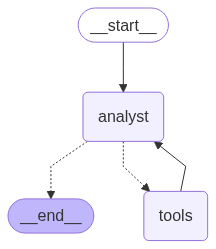

In [6]:
# Create the graph
Researcher = StateGraph(State)

# Add the nodes
Researcher.add_node("analyst", analyst)
Researcher.add_node("tools", ToolNode(tools=tools))

# Add conditional edges
Researcher.add_conditional_edges(
    "analyst",  # Node to start from
    tools_condition,  # Function that determines which node to go to next
    {
        "tools": "tools",  # If tools are needed
        END: END  # If no tools are needed
    }
)

# Add the remaining edges
Researcher.add_edge(START, "analyst")
Researcher.add_edge("tools", "analyst")

# Compile the graph
Researcher = Researcher.compile(checkpointer=memory)

# Display the graph
display_graph(Researcher)

In [ ]:
config = {'configurable':{'thread_id':"1"}}
user_input = """Please analyze the sentiment of Iran Khodro (ایران خودرو) in today's news. Follow these steps:

1. Search for recent news about Iran Khodro (ایران خودرو)
2. For each relevant article or source:
   - Provide the source URL
   - Summarize the key points
   - Rate the sentiment on a scale of 1-10 where:
     * 1-3: Very Negative
     * 4-5: Slightly Negative
     * 6: Neutral
     * 7-8: Slightly Positive
     * 9-10: Very Positive
3. Explain the reasoning behind each sentiment score
4. Calculate an overall sentiment score based on all sources

Please present your findings in a clear, structured format in English."""

response = Researcher.invoke({'messages' : user_input}, config=config)

In [ ]:
def display_chat(messages):
    """Display chat messages in a readable format and save to a text file"""
    output = []
    
    for msg in messages:
        if msg.type == 'human':
            formatted = f"\n👤 Query:\n{msg.content}\n"
            print(formatted)
            output.append(formatted)
        elif msg.type == 'ai':
            formatted = f"🤖 Analysis Results:\n{msg.content}\n"
            print(formatted)
            output.append(formatted)
            
            # Optionally display reasoning if available
            if 'reasoning_content' in msg.additional_kwargs:
                reasoning = f"🤔 Additional Analysis:\n{msg.additional_kwargs['reasoning_content']}\n"
                print(reasoning)
                output.append(reasoning)
            
            # Display token usage if available
            if hasattr(msg, 'response_metadata') and msg.response_metadata:
                usage = msg.response_metadata.get('token_usage', {})
                stats = (
                    "\n📊 Analysis Statistics:\n"
                    f"   - Total tokens: {usage.get('total_tokens', 'N/A')}\n"
                    f"   - Processing time: {usage.get('total_time', 'N/A'):.2f}s\n"
                )
                print(stats)
                output.append(stats)
    
    # Save the results to a text file
    with open('sentiment_analysis_results.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(output))
    print("\n📝 Results have been saved to 'sentiment_analysis_results.txt'")

# Display the messages nicely
display_chat(response['messages'])


👤 Human: what is the sentiment from 1 -10 about Iran Khodro  ایران خودرو in the news today ? Provide your answer in English.

🤖 AI: To determine the sentiment about Iran Khodro in the news today, we need to perform a search query. Here's how we can do it:



📊 Stats:
   - Total tokens: 2168
   - Processing time: 0.22s

🤖 AI: The sentiment about Iran Khodro in the news today is negative, with a score of around 3 out of 10. The news articles mention that the Iranian Regulatory Authority has stopped Iran Khodro from selling its products at new prices, citing "excessive pricing" and "illegal price increases" of over 8 trillion tomans (approximately $190 million USD). This has led to a reaction from the company, which has issued a statement protesting the decision. Overall, the news is unfavorable for Iran Khodro, indicating a negative sentiment.

📊 Stats:
   - Total tokens: 3437
   - Processing time: 0.42s

